In [14]:
import photutils, astropy
from photutils import datasets
from astropy.modeling.functional_models import Sersic2D

import numpy
import matplotlib.pyplot as plt

from astropy import visualization, convolution, stats

from collections import OrderedDict

import time

# Level 1

## Step 1: Mock data generation

In [16]:
#model = Sersic2D(amplitude = 3, r_eff = 25, n=4, x_0=50, y_0=50,
#               ellip=.5, theta=-1)

start = time.time()

model = Sersic2D()
n_sources = 200
shape = (2000, 2000)
param_ranges = [('amplitude', [100, 200]),
                ('r_eff', [5, 35]),
                ('x_0', [0, shape[1]]),
                ('y_0', [0, shape[0]]),
                ('n', [0.8, 4]),
                ('ellip', [0, 5]),
                ('theta', [-2, 2])]
param_ranges = OrderedDict(param_ranges)
sources = datasets.make_random_models_table(n_sources, param_ranges,
                                   random_state=12344)
data = datasets.make_model_sources_image(shape, model, sources)

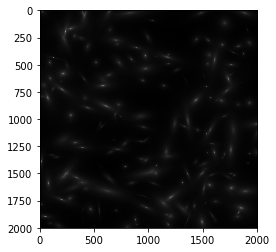

In [17]:
norm = visualization.mpl_normalize.ImageNormalize(
    stretch=visualization.SqrtStretch())

#plt.imshow(data)
plt.imshow(data, cmap='Greys_r', norm=norm)

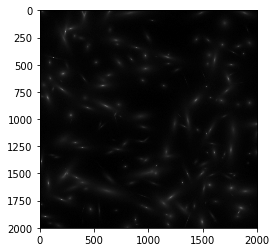

In [18]:
noise_data = datasets.apply_poisson_noise(data)
plt.imshow(noise_data, cmap='Greys_r', norm=norm)

## Step 2: Detection on mock data

In [19]:
data = noise_data
threshold = photutils.detect_threshold(data, snr=2.0)
sigma = 3.0 * stats.gaussian_fwhm_to_sigma
kernel = convolution.Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segments = photutils.detect_sources(
    data, threshold, npixels=5, filter_kernel=kernel)
deblended = photutils.deblend_sources(data, segments, npixels=5, 
                               filter_kernel=kernel, nlevels=32,
                               contrast=0.001)

In [20]:
props = photutils.source_properties(data, deblended)
scale = 3.5
apertures = [photutils.EllipticalAperture(
    (i.xcentroid.value, i.ycentroid.value),
    i.semimajor_axis_sigma.value * scale,
    i.semiminor_axis_sigma.value * scale,
    theta=i.orientation.value) for i in props]

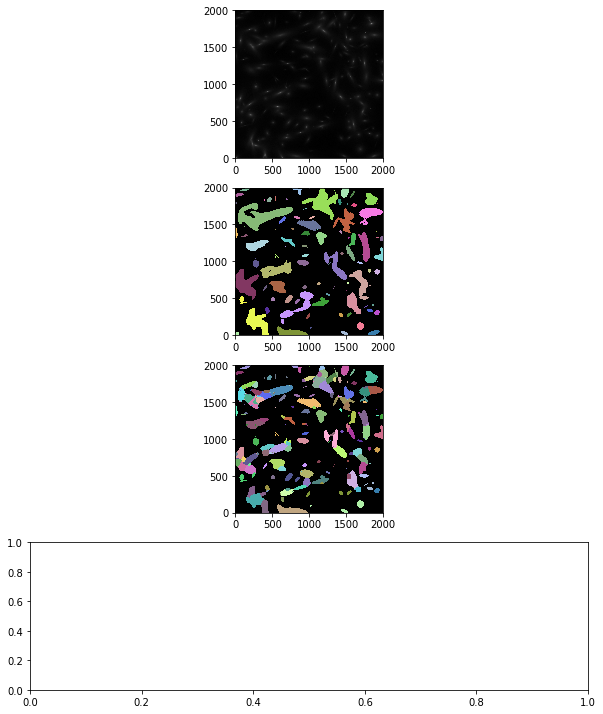

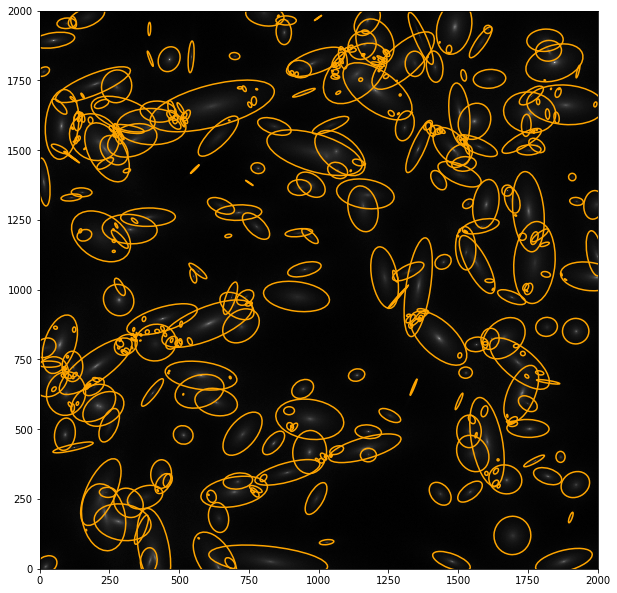

In [21]:
norm = visualization.mpl_normalize.ImageNormalize(
    stretch=visualization.SqrtStretch())
fig, ax = plt.subplots(4, 1, figsize=(10, 12.5))
ax[0].imshow(data, origin='lower', cmap='Greys_r', norm=norm)

ax[1].imshow(segments, origin='lower', cmap=segments.cmap(random_state=12345))
ax[2].imshow(deblended, origin='lower', cmap=segments.cmap(random_state=12345))

fig, (axyeet) = plt.subplots(1, 1, figsize=(10, 12.5))
axyeet.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
for i in apertures: i.plot(color='orange', lw=1.5, ax=axyeet)

In [22]:
print(f"{time.time() - start} elapsed.")

84.37484741210938 elapsed.
